# Forward model in different architectures


## Import modules

In [1]:
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import h5py

import helper  # some helper functions

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-03 16:57:34.416416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 16:57:34.940154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-03 16:57:35.903046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 16:57:35.923316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Data loading

Here we load the data saved in the data generation tutorial. As the thicknesses and materials have a large difference in values and different units, they are normalized with _MinMaxScaler_ scaler in [0,1] range. Otherwise the network training would be disrupted. Thickness and material data are concatenated in channel dimension and split into training and test sets.

*Note*: We demonstrate the data loading and normalization here explicitly. In the further notebooks it is done using functions from the provided *helper* module.

In [2]:
# data loading
path_h5 = 'datasets/dataset1_random.h5'  # data path

with h5py.File(path_h5) as f_read:
    R_spec = np.array(f_read['R'], dtype=np.float32)
    mat = np.array(f_read['mat'], dtype=np.float32)
    thick = np.array(f_read['thick'], dtype=np.float32)
    wavelengths = np.array(f_read['wavelengths'], dtype=np.float32)

# we add a channel dimension to the spectra (keras: channels last)
R_spec = np.expand_dims(R_spec, -1)

#  separately standardize permittivities and thicknesses
scaler_mat = StandardScaler().fit(mat)
mat = scaler_mat.transform(mat)
scaler_thick = StandardScaler().fit(thick)
thick = scaler_thick.transform(thick)

# save the scalers using pickle
pickle.dump([scaler_mat, scaler_thick], 
            open('{}_scalers.pkl'.format(os.path.splitext(path_h5)[0]), 'wb'))

# concatenate materials and thicknesses. keras: last dimension is channel
mat_thick = np.stack([mat, thick], axis=-1)

# split into training and test datasets. Set random state for a reproducible splitting
x_train, x_test, y_train, y_test = train_test_split(
    mat_thick, R_spec, test_size=0.05, random_state=2)

print('mat_thick shape :', mat_thick.shape)

mat_thick shape : (50000, 5, 2)


# 1. VGG style convolutional network

## Architecture

The first architecture is a simple stacking of convolution layers followed by _Batchnormalization_ and _LeakyReLU_ activation function to make a deep neural network, the term "deep" refers to the fact that the network has more than one hidden layer. This architecture reduces the spatial dimensions while increase in depth. At the end of the model we have a fully cpnnected layer that ouptus the wavelenghts predicted by the neural network model.


### A note on batch normalization:
It is often recommended to use batch normalization (BN) before (some also recommend after) every activation, arguing that the nonlinearity and/or slope of the activation can then be ideally exploited. The benefit of BN actually strongly depends on the problem, on the data and on the network architecture. For instance, in small networks with normalized data, BN is often not very useful, because the data normalization is more or less conserved through later layers. In such cases, batchnorm often slows down the training because of the computational everhead. In regression problems, in particular if the data has large variance, the individual batch statistics can vary significantly which likely has a negative impact on the quantitiative, absolute network prediction.

We will therefore not use BN and rather limit the models to a reasonable number of layers (say below around 20 convolution operations). We provide a separate notebook to demonstrate the effect of batchnorm.

In [3]:
# CNN that transforms the data dim from 5-layer geometries (5, 2) to R-spectra (64, 1)
keras.backend.clear_session()
N_conv = 4

# input
VGG_input = keras.layers.Input(shape=mat_thick.shape[1:])
# add zeros on left and right to adapt the shape (5, 2) --> (8, 2)
x = keras.layers.ZeroPadding1D((1, 2))(VGG_input)

for i in range(N_conv):  # repeat several convolutions
    x = keras.layers.Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
x = keras.layers.UpSampling1D()(x)   # 8 --> 16

for i in range(N_conv):
    x = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
x = keras.layers.UpSampling1D()(x)   # 16 --> 32

for i in range(N_conv):
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
x = keras.layers.UpSampling1D()(x)   # 32 --> 64

for i in range(N_conv):
    x = keras.layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)

# output
VGG_output = keras.layers.Conv1D(filters=1, kernel_size=1, padding='same')(x)

VGG_model = keras.models.Model(
    inputs=VGG_input, outputs=VGG_output, name='vgg_model')

VGG_model.summary()  # print the model architecture


2023-07-03 16:57:36.748386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 16:57:36.748595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 16:57:36.748718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "vgg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2)]            0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 8, 2)             0         
 1D)                                                             
                                                                 
 conv1d (Conv1D)             (None, 8, 256)            1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 256)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 256)            196864    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 256)            0         
                                                         

## VGG model training

### compilation
The model needs to be compiled with the optimizer algorith, here the SGD variant "*Adam*", and the loss functions, here the mean squared error.

### callbacks
We can optionally add callback functions that are called after each epoch (=one full training iteration on the dataset). Here we demonstrate this with an automatic learning rate decrease schedule and with an early stopping detector (that stops when overfitting is detected during a certain number of epochs). The `ModelCheckpoint` callback finally saves the model to disc, every time a new best validation loss is obtained.

### training
The network training is launched with the model's `fit` function. The training data is passed and we can also specify a ratio for validation (or pass a separate validation set via kwarg `validation_data=(x_val, y_val)`).

*Note* since we do not use batchnorm, the initial training rate is significiantly lower here, than in the further examples with batchnorm.

In [4]:
# compile model with an optimizer and a loss
VGG_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0005),
                  loss='mse')

# callback to reduce learning rate if training stagnates
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/3, patience=5, verbose=1)

# callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# callback for checkpoint saving
checkpoint_save = ModelCheckpoint(
    filepath='checkpoints/vgg/', monitor='val_loss', save_weights_only=True, save_best_only=True)


# we use the fit-function's validation split. The test data is used later
history = VGG_model.fit(x=x_train, y=y_train,
                        validation_split=0.2,
                        batch_size=32,
                        epochs=50,
                        callbacks=[reduce_lr, checkpoint_save, early_stopping])

Epoch 1/50


2023-07-03 16:57:40.213438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-03 16:57:42.307603: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d4fa287c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 16:57:42.307638: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-03 16:57:42.313763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 16:57:42.477636: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1188/1188 [==============================] - ETA: 0s - loss: 0.0152

2023-07-03 16:58:10.258229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1188/1188 [==============================] - 36s 22ms/step - loss: 0.0152 - val_loss: 0.0071 - lr: 5.0000e-04
Epoch 2/50
1188/1188 [==============================] - 21s 17ms/step - loss: 0.0045 - val_loss: 0.0026 - lr: 5.0000e-04
Epoch 3/50
1188/1188 [==============================] - 21s 18ms/step - loss: 0.0024 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 4/50
1188/1188 [==============================] - 20s 17ms/step - loss: 0.0017 - val_loss: 0.0019 - lr: 5.0000e-04
Epoch 5/50
1188/1188 [==============================] - 21s 17ms/step - loss: 0.0014 - val_loss: 0.0011 - lr: 5.0000e-04
Epoch 6/50
1188/1188 [==============================] - 21s 18ms/step - loss: 0.0013 - val_loss: 0.0010 - lr: 5.0000e-04
Epoch 7/50
1188/1188 [==============================] - 21s 18ms/step - loss: 0.0011 - val_loss: 0.0013 - lr: 5.0000e-04
Epoch 8/50
1188/1188 [==============================] - 21s 17ms/step - loss: 0.0010 - val_loss: 6.9237e-04 - lr: 5.0000e-04
Epoch 9/50
1188/1188 [=================

## Plot train and validation losses 

The evolution of the losses usually reveals overfitting and/or underfitting. 

 - Overfitting: After initially decreasing, the validation loss increases again while the training loss continues decreasing
 
 - Underfitting: Typically after a rather short training period, neither training nor validation loss decreases significantly

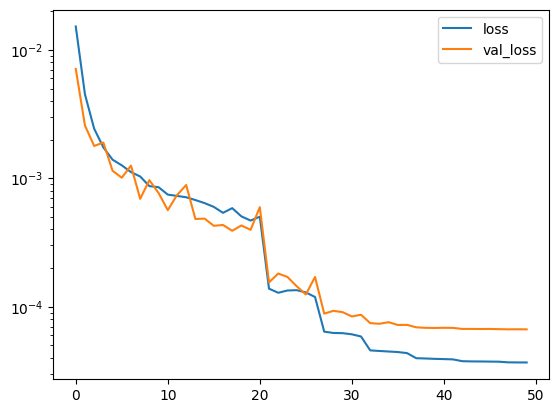

In [5]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

## VGG model test

The model is tested with the test dataset to see its capacity on unseen data. From predictions, six random responses are picked to show in figure and we can see that they are not accurate.

*Note*: the below explicitly written histogram and random sample plots are available in the `helper` module: `helper.plot_benchmark_R_model`

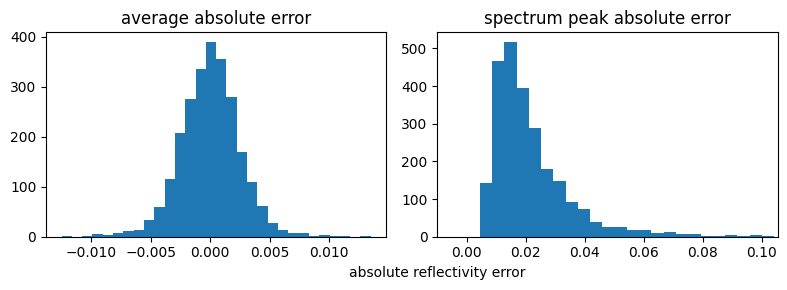

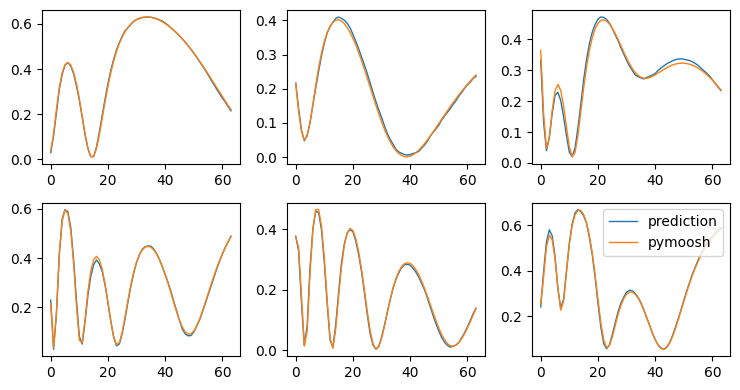

In [6]:
y_predict_1 = VGG_model.predict(x_test, verbose=0)
N_plot = (2, 3)

# plot statistics
err = y_predict_1 - y_test
err_mean = np.mean(err, axis=(1,2))
err_max = np.max(np.abs(err), axis=(1,2))
plt.figure(figsize=(8,3))
plt.subplot(121, title='average absolute error')
plt.hist(err_mean, bins=30)
plt.subplot(122, title='spectrum peak absolute error')
plt.hist(err_max, bins=50)
plt.xlabel('absolute reflectivity error', x=0)
plt.xlim(-0.01, np.quantile(err_max, 0.995)) # don't plot outliers
plt.tight_layout()
plt.show()

# plot samples
if N_plot is not None:
    plt.figure(figsize=(2.5*N_plot[1], 2*N_plot[0]))
    idx_rnd = np.random.randint(len(x_test), size=np.prod(N_plot))
    for i, index in enumerate(idx_rnd):
        plt.subplot(N_plot[0], N_plot[1], i+1)
        plt.plot(y_predict_1[index], label='prediction', linewidth=1)
        plt.plot(y_test[index], label='pymoosh', linewidth=1)
    plt.legend()
    plt.tight_layout()
    plt.show()

### VGG model saving

In [7]:
VGG_model.save('models/fwd_model_VGG.h5')

# 2. ResNet

## resnet block

This block contains a stack of convolution layers and a skip connection that adds the stack input to its output in order to avoid information lost when neural network goes deeper.

*A note on batch norm*: See VGG intro text above for an explanation why we do not use batchnorm here.

*Note*: We demonstrate an example for an implementation here explicitly. The same residual block is also provided in the *helper* module.

In [8]:
def residual_block(x_in, N_filter, kernel_size=3, strides=1,
                   conv_layer=keras.layers.Conv1D, alpha=0.3,
                   with_BN=False):
    """resnet block, default: 1D convolutions"""

    # residual connection
    if x_in.shape[-1] != N_filter or strides != 1:
        # if input!=output dimension: add BN/ReLU/conv. into shortcut
        conv_shortcut=conv_layer(
            filters=N_filter, kernel_size=1, strides=strides, padding='same')(x_in)
    else:
        # if input==output dimension: use bare input as shortcut
        conv_shortcut=x_in

    # convolutional path
    x=x_in

    x=conv_layer(filters=N_filter, kernel_size=1, strides=1,
                            padding='same', use_bias=not with_BN)(x)
    if with_BN:
        x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha)(x)

    x=conv_layer(filters=N_filter, kernel_size=kernel_size,
                            strides=strides, padding='same', use_bias=not with_BN)(x)
    if with_BN:
        x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha)(x)

    x=conv_layer(filters=N_filter, kernel_size=1, strides=1,
                            padding='same', use_bias=not with_BN)(x)
    if with_BN:
        x=keras.layers.BatchNormalization()(x)

    # add residual and main and apply a further activation
    x=keras.layers.Add()([x, conv_shortcut])
    x=keras.layers.LeakyReLU(alpha)(x)

    return x

## resnet block stack

The model is made of many resnet blocks.

In [9]:
keras.backend.clear_session()
N_blocks = 4     # Nr of resblocks between upsamplings


# input
resnet_input = keras.layers.Input(shape=(mat_thick.shape[1:]))

x = keras.layers.ZeroPadding1D((1, 2))(resnet_input)  # (5, 2) --> (8, 2)
x = keras.layers.Conv1D(filters=256, kernel_size=3,
                        strides=1, padding='same')(x)

for i in range(N_blocks):
    x = residual_block(x, N_filter=256, kernel_size=3, strides=1)
x = keras.layers.UpSampling1D()(x)  # data dim.: 8 --> 16

for i in range(N_blocks):
    x = residual_block(x, N_filter=128, kernel_size=3, strides=1)
x = keras.layers.UpSampling1D()(x)  # 16 --> 32

for i in range(N_blocks):
    x = residual_block(x, N_filter=64, kernel_size=3, strides=1)
x = keras.layers.UpSampling1D()(x)  # 32 --> 64

for i in range(N_blocks):
    x = residual_block(x, N_filter=32, kernel_size=3, strides=1)

x = residual_block(x, N_filter=32, kernel_size=3, strides=1, with_BN=False)

# output
resnet_outputs = keras.layers.Conv1D(1, kernel_size=1, padding='same')(x)

# full model
resnet_model = keras.models.Model(
    inputs=resnet_input, outputs=resnet_outputs, name='resnet_model')
resnet_model.summary()


Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 2)]       0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 8, 2)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 8, 256)       1792        ['zero_padding1d[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8, 256)       65792       ['conv1d[0][0]']                 
                                                                                       

## ResNet model training

In [10]:
# compile with optimizer and cost function
resnet_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
                     loss='mse')

# atuomatic learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/3, patience=5, verbose=1)

# automatic early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

# callback for checkpoint saving
checkpoint_save = ModelCheckpoint(filepath='checkpoints/resnet/',
                                  monitor='val_loss', save_weights_only=True, save_best_only=True)


# fit the model
history = resnet_model.fit(x=x_train, y=y_train,
                           validation_split=.2,
                           batch_size=32, epochs=50,
                           callbacks=[reduce_lr, checkpoint_save, early_stopping])

Epoch 1/50


1188/1188 [==============================] - 60s 38ms/step - loss: 0.0240 - val_loss: 0.0096 - lr: 0.0010
Epoch 2/50
1188/1188 [==============================] - 44s 37ms/step - loss: 0.0059 - val_loss: 0.0033 - lr: 0.0010
Epoch 3/50
1188/1188 [==============================] - 44s 37ms/step - loss: 0.0029 - val_loss: 0.0020 - lr: 0.0010
Epoch 4/50
1188/1188 [==============================] - 44s 37ms/step - loss: 0.0023 - val_loss: 0.0017 - lr: 0.0010
Epoch 5/50
1188/1188 [==============================] - 43s 36ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 0.0010
Epoch 6/50
1188/1188 [==============================] - 42s 36ms/step - loss: 0.0020 - val_loss: 0.0013 - lr: 0.0010
Epoch 7/50
1188/1188 [==============================] - 41s 35ms/step - loss: 0.0019 - val_loss: 0.0023 - lr: 0.0010
Epoch 8/50
1188/1188 [==============================] - 43s 36ms/step - loss: 0.0017 - val_loss: 0.0010 - lr: 0.0010
Epoch 9/50
1188/1188 [==============================] - 42s 36ms/step - los

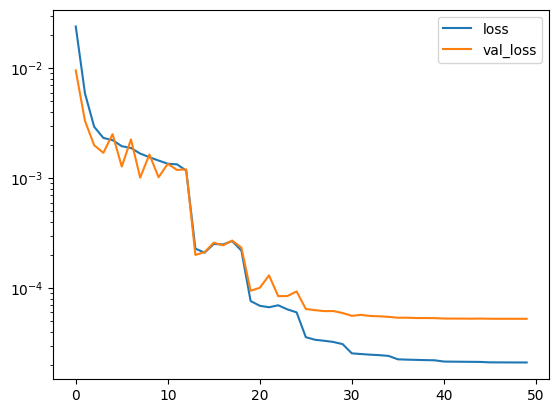

In [11]:
# plot the learning convergence
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

## ResNet model test

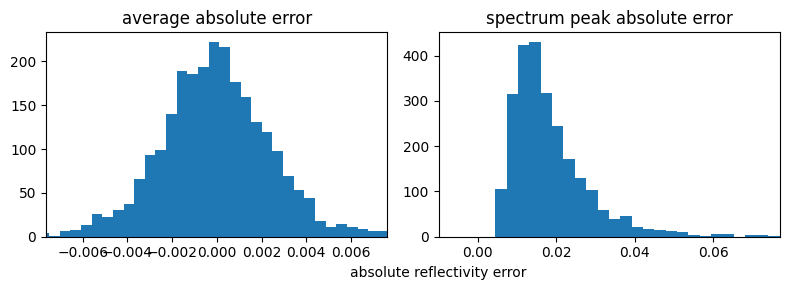

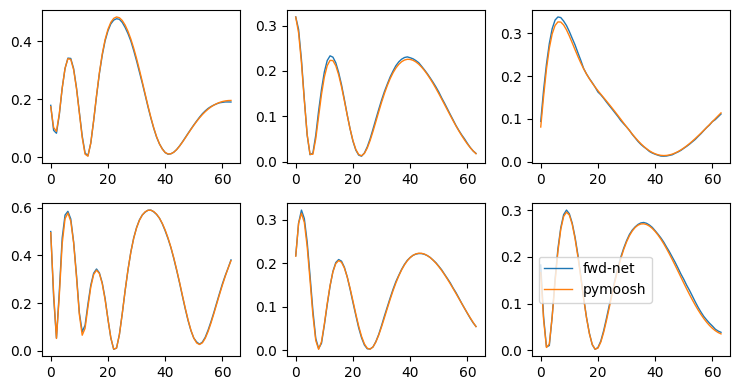

In [12]:
y_predict_2 = resnet_model.predict(x_test, verbose=0)
helper.plot_benchmark_R_model(y_predict_2, y_test, N_plot=(2,3))

###  ResNet model saving

In [13]:
resnet_model.save('models/fwd_model_resnet.h5')

# 3. Identity mapping ResNet

The key contribution of the ResNet was the ability to train very deep networks, which was not possible before. However, also the standard resnet learning slows down for extremely deep architectures, in the order of several hundreds of convolutional layers. A slight variation of the residual block can circumvent this problem. So-called identitiy mapping blocks allow to effectively train networks with more than thousand convolutional layers. We show below how this works, for the sake of training time we keep the depth of the model similar to the resnet above, so the performance is also comparable.

## Identity mapping block

This block is close to the "classic" ResNet block but with improvements in the layers arrangement for particularly deep architectures. The modification is a complete removal of any operation / activation function from the shortcut path, hence by default it represents a true identity mapping.
Like in the conventional residual block, in cases when there is an inconsistency between the input and output dimensions, a convolution is added to the shortcut.

*Note*: We demonstrate an example for an implementation here explicitly. The same residual identity mapping block is also provided in the *helper* module.

In [14]:
def id_map_conv_block(x_in, N_filter, kernel_size=3, strides=1, alpha=0.3, with_BN=False):
    'Res-net identity mapping block'
    x = x_in
    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha)(x)

    # residual connection
    if x_in.shape[-1] != N_filter or strides != 1:
        # if input!=output dimension: add BN/ReLU/conv. into shortcut
        conv_shortcut = keras.layers.Conv1D(
            filters=N_filter, kernel_size=1, strides=strides, padding='same')(x_in)
    else:
        # if input==output dimension: use bare input as shortcut
        conv_shortcut = x_in

    # main convolution path
    x = keras.layers.Conv1D(filters=N_filter, kernel_size=1,
                            strides=strides, padding='same', use_bias=not with_BN)(x)

    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Conv1D(filters=N_filter, kernel_size=kernel_size,
                            strides=1, padding='same', use_bias=not with_BN)(x)

    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha)(x)
    x = keras.layers.Conv1D(filters=N_filter, kernel_size=1,
                            strides=1, padding='same', use_bias=not with_BN)(x)

    # add shortcut and main path
    x = keras.layers.Add()([x, conv_shortcut])
    return x

## construct the resnet using identity mapping blocks

In [15]:
keras.backend.clear_session()
N_blocks = 4

# input
id_resnet_input = keras.layers.Input(shape=(mat_thick.shape[1:]))
x = keras.layers.ZeroPadding1D((1, 2))(id_resnet_input)  # (5, 2) --> (8, 2)

# a first convolution since the id_map_conv_block starts with BN+activation
x = keras.layers.Conv1D(filters=256, kernel_size=3,
                        strides=1, padding="same")(x)

for i in range(N_blocks):
    x = id_map_conv_block(x, N_filter=256, strides=1)
x = keras.layers.UpSampling1D()(x)   # 8 --> 16

for i in range(N_blocks):
    x = id_map_conv_block(x, N_filter=128, strides=1)
x = keras.layers.UpSampling1D()(x)   # 16 --> 32

for i in range(N_blocks):
    x = id_map_conv_block(x, N_filter=64, strides=1)
x = keras.layers.UpSampling1D()(x)   # 32 --> 64

for i in range(N_blocks):
    x = id_map_conv_block(x, N_filter=32, strides=1)

x = id_map_conv_block(x, N_filter=32, strides=1, with_BN='False')

# output
id_resnet_output = keras.layers.Conv1D(
    filters=1, kernel_size=1, padding='same')(x)

id_resnet_model = keras.models.Model(
    inputs=id_resnet_input, outputs=id_resnet_output, name='id_resnet_model')
id_resnet_model.summary()

Model: "id_resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 2)]       0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 8, 2)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 8, 256)       1792        ['zero_padding1d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 256)       0           ['conv1d[0][0]']                 
                                                                                    

## identity mapping ResNet training

Compile the model and define callbacks

In [16]:
# compile with optimizer and cost function
id_resnet_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.002),
                        loss='mse')

# atuomatic learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/3, patience=5, verbose=1)

# automatic early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

# callback for checkpoint saving
checkpoint_save = ModelCheckpoint(
    filepath='checkpoints/id_resnet/', monitor='val_loss', save_weights_only=True, save_best_only=True)

### Fit the model

Epoch 1/50
1188/1188 [==============================] - 56s 36ms/step - loss: 0.0583 - val_loss: 0.0236 - lr: 0.0020
Epoch 2/50
1188/1188 [==============================] - 42s 36ms/step - loss: 0.0154 - val_loss: 0.0105 - lr: 0.0020
Epoch 3/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0076 - val_loss: 0.0052 - lr: 0.0020
Epoch 4/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0045 - val_loss: 0.0034 - lr: 0.0020
Epoch 5/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0037 - val_loss: 0.0042 - lr: 0.0020
Epoch 6/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0036 - val_loss: 0.0026 - lr: 0.0020
Epoch 7/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0036 - val_loss: 0.0039 - lr: 0.0020
Epoch 8/50
1188/1188 [==============================] - 42s 35ms/step - loss: 0.0034 - val_loss: 0.0059 - lr: 0.0020
Epoch 9/50
1188/1188 [==============================] - 42s 35ms

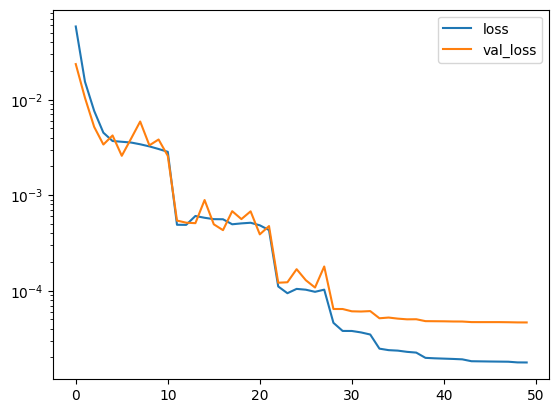

In [17]:
# fit the model
history = id_resnet_model.fit(x=x_train, y=y_train,
                              validation_split=.2,
                              batch_size=32, epochs=50,
                              callbacks=[reduce_lr, checkpoint_save, early_stopping])

# plot loss
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

## Id_ResNet model test


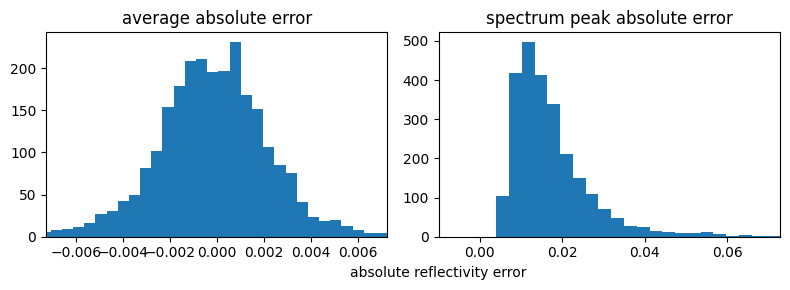

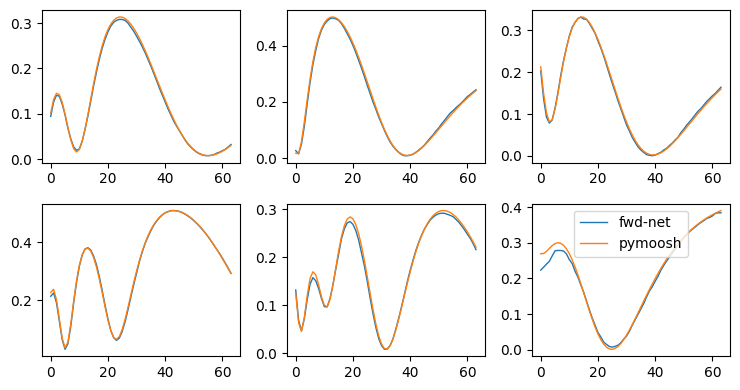

In [18]:
y_predict_3 = id_resnet_model.predict(x_test, verbose=0)
helper.plot_benchmark_R_model(y_predict_3, y_test, N_plot=(2,3))

### Id_ResNet model saving

In [19]:
id_resnet_model.save('models/fwd_model_id_resnet.h5')

# 4. ResNeXt, ConvNeXt 

A modern variant of the resNet is the so-called "ResNeXt" (or a more sophisticated variant: "ConvNeXt"). It implements architectural choices inspired from vision transformers (see [Saining Xie, Ross Girshick, Piotr Dollár, Zhuowen Tu, and Kaiming He. *Aggregated residual transformations for deep neural networks*. In CVPR, 2017]). While transformer networks typically require gigantic datasets (in the order of millions of samples), the advantage of resNeXt and ConvNeXt is its strong performance also on smaller dataset sizes.

Because of the high depth of the network that we will use, batchnorm becomes necessary for training convergence. In order to circumvent statistical problems on our regression task, we therefore employ a batch-size increase schedule, together with an automatic learning rate decay (see [Smith, S. L., Kindermans, P.-J., Ying, C. & Le, Q. V. *Don’t Decay the Learning Rate, Increase the Batch Size*. arXiv:1711.00489 (2018)]).


## resNeXt block

Similar to the above examples we implement here a 1D resNeXt block that is subsequently used to define the full model. The concept modifies the classical res-block using grouped convolutions and bottleneck layers.

In [20]:
def resNeXt_block(x_in, N_filter, N_groups, N_bottleneck, kernel_size=3, strides=1,
                   conv_layer=keras.layers.Conv1D, alpha=0.3, with_BN=True):
    """ResNeXt block, default: 1D convolutions"""
    
    # residual connection
    if x_in.shape[-1] != N_filter or strides != 1:
        # if input!=output dimension: add BN/ReLU/conv. into shortcut
        conv_shortcut = conv_layer(
            filters=N_filter, kernel_size=1, strides=strides, padding='same')(x_in)
    else:
        # if input==output dimension: use bare input as shortcut
        conv_shortcut = x_in
    if with_BN:
        conv_shortcut = keras.layers.BatchNormalization()(conv_shortcut)


    # resnext path
    N_bottleneck_filters = int(N_filter * N_bottleneck)
    x = x_in

    x = conv_layer(filters=N_bottleneck_filters, kernel_size=1, strides=1,
                            padding='same', use_bias=not with_BN)(x)
    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha)(x)

    x = conv_layer(filters=N_bottleneck_filters, kernel_size=kernel_size,
                   strides=strides, padding='same', 
                   groups=N_bottleneck_filters//N_groups, use_bias=not with_BN)(x)
    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha)(x)

    x = conv_layer(filters=N_filter, kernel_size=1, strides=1,
                   padding='same', use_bias=not with_BN)(x)
    if with_BN:
        x = keras.layers.BatchNormalization()(x)

    # add residual and main and apply a further activation
    x = keras.layers.Add()([x, conv_shortcut])
    x = keras.layers.LeakyReLU(alpha)(x)

    return x

## define the resNeXt model

In [21]:
keras.backend.clear_session()
N_blocks = 4


# input
resnext_input = keras.layers.Input(shape=(mat_thick.shape[1:]))
x = keras.layers.ZeroPadding1D((1, 2))(resnext_input)  # (5, 2) --> (8, 2)

# a first convolution since the id_map_conv_block starts with BN+activation
x = keras.layers.Conv1D(filters=256, kernel_size=3,
                        strides=1, padding="same")(x)

for i in range(N_blocks):
    x = resNeXt_block(x, N_filter=256, N_groups=32, N_bottleneck=4, strides=1)
x = keras.layers.UpSampling1D()(x)   # 8 --> 16

for i in range(N_blocks):
    x = resNeXt_block(x, N_filter=128, N_groups=32, N_bottleneck=4, strides=1)
x = keras.layers.UpSampling1D()(x)   # 16 --> 32

for i in range(N_blocks):
    x = resNeXt_block(x, N_filter=64, N_groups=32, N_bottleneck=4, strides=1)
x = keras.layers.UpSampling1D()(x)   # 32 --> 64

for i in range(N_blocks):
    x = resNeXt_block(x, N_filter=32, N_groups=32, N_bottleneck=4, strides=1)

x = resNeXt_block(x, N_filter=32, N_groups=32,
                  N_bottleneck=4, strides=1, with_BN='False')

# output
resnext_output = keras.layers.Conv1D(
    filters=1, kernel_size=1, padding='same')(x)

resnext_model = keras.models.Model(
    inputs=resnext_input, outputs=resnext_output, name='resnext_model')
resnext_model.summary()


Model: "resnext_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 2)]       0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 8, 2)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 8, 256)       1792        ['zero_padding1d[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8, 1024)      262144      ['conv1d[0][0]']                 
                                                                                      

## train the resNeXt model

As discussed above the model uses batchnorm and there we employ a simple batch-size increase schedule

Epoch 1/25
2375/2375 [==============================] - 188s 66ms/step - loss: 0.0235 - val_loss: 0.0107 - lr: 0.0100
Epoch 2/25
2375/2375 [==============================] - 154s 65ms/step - loss: 0.0091 - val_loss: 0.0071 - lr: 0.0100
Epoch 3/25
2375/2375 [==============================] - 154s 65ms/step - loss: 0.0071 - val_loss: 0.0074 - lr: 0.0100
Epoch 4/25
2375/2375 [==============================] - 155s 65ms/step - loss: 0.0065 - val_loss: 0.0072 - lr: 0.0100
Epoch 5/25
2375/2375 [==============================] - 154s 65ms/step - loss: 0.0056 - val_loss: 0.0088 - lr: 0.0100
Epoch 6/25
2375/2375 [==============================] - 157s 66ms/step - loss: 0.0047 - val_loss: 0.0050 - lr: 0.0100
Epoch 7/25
2375/2375 [==============================] - 155s 65ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 0.0100
Epoch 8/25
2375/2375 [==============================] - 155s 65ms/step - loss: 0.0039 - val_loss: 0.0030 - lr: 0.0100
Epoch 9/25
2375/2375 [==============================] - 

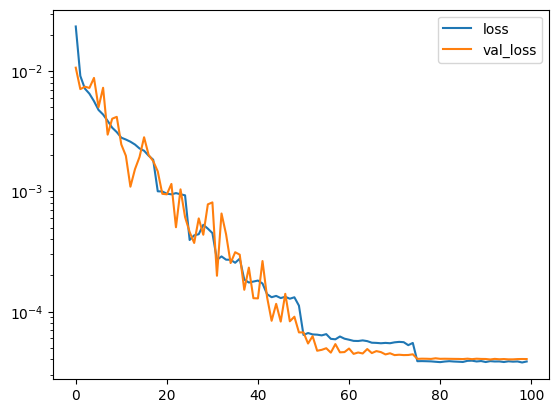

In [22]:
# compile with optimizer and cost function
resnext_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.01),
                      loss='mse')

# atuomatic learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/2, patience=5, verbose=1)

# callback for checkpoint saving
checkpoint_save = ModelCheckpoint(
    filepath='checkpoints/resnext/', monitor='val_loss', save_weights_only=True, save_best_only=True)

# assemble fit config
train_kwargs = dict(x=x_train, y=y_train, validation_split=.2,
                    epochs=25, callbacks=[reduce_lr, checkpoint_save])

# fit the model with BN --> increasing batchsize schdedule
hist = None  # global history after BS incrase
for i in range(4):  # 4x15 epochs, increasing batchsize
    _h = resnext_model.fit(batch_size=(16 * 2**i), **train_kwargs)
    if hist is None:
        hist = _h
    else:
        for k in hist.history:
            hist.history[k] = np.concatenate([hist.history[k], _h.history[k]])

# plot loss
plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

## Test the resNeXt

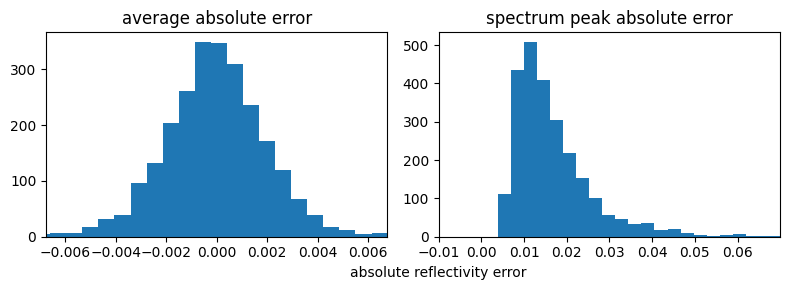

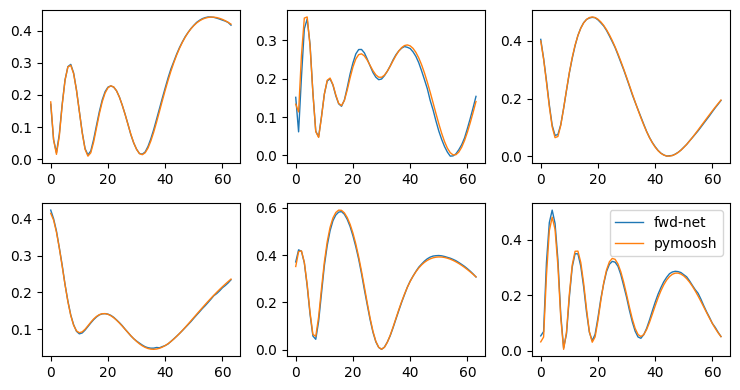

In [23]:
y_predict_4 = resnext_model.predict(x_test, verbose=0)
helper.plot_benchmark_R_model(y_predict_4, y_test, N_plot=(2,3))